In [2]:
import zipfile
with zipfile.ZipFile(R"C:\Users\HP\Downloads\archive (14).zip") as f:
    f.extractall('DATASET')

In [3]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import os
import matplotlib.pyplot as plt

DATASET_DIR = 'DATASET'
IMG_SIZE = (48, 48)  
BATCH_SIZE = 64
SEED = 42

# data loading only done here 
print("Loading Training Data...")
train_ds = tf.keras.utils.image_dataset_from_directory(
    os.path.join(DATASET_DIR, 'train'),
    labels='inferred',
    label_mode='categorical', 
    image_size=IMG_SIZE,
    interpolation='nearest',
    seed=SEED,
    batch_size=BATCH_SIZE
)

print("Loading Validation Data ")

val_ds = tf.keras.utils.image_dataset_from_directory(
    os.path.join(DATASET_DIR, 'test'),
    labels='inferred',
    label_mode='categorical',
    image_size=IMG_SIZE,
    interpolation='nearest',
    seed=SEED,
    batch_size=BATCH_SIZE
)

CLASS_NAMES = train_ds.class_names
NUM_CLASSES = len(CLASS_NAMES)
print(f"\nDetected Classes: {CLASS_NAMES}")
print(f"Number of Classes: {NUM_CLASSES}")


AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

normalization_layer = tf.keras.layers.Rescaling(1./255)
train_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
val_ds = val_ds.map(lambda x, y: (normalization_layer(x), y))

Loading Training Data...
Found 28709 files belonging to 7 classes.
Loading Validation Data 
Found 7178 files belonging to 7 classes.

Detected Classes: ['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']
Number of Classes: 7


In [4]:
def create_model():
    model = Sequential([
        
        Conv2D(32, (3, 3), padding='same', activation='relu', input_shape=(IMG_SIZE[0], IMG_SIZE[1], 3)),
        BatchNormalization(),
        Conv2D(32, (3, 3), activation='relu'),
        BatchNormalization(),
        MaxPooling2D(pool_size=(2, 2)),
        Dropout(0.25),

        
        Conv2D(64, (3, 3), padding='same', activation='relu'),
        BatchNormalization(),
        Conv2D(64, (3, 3), activation='relu'),
        BatchNormalization(),
        MaxPooling2D(pool_size=(2, 2)),
        Dropout(0.25),

        
        Conv2D(128, (3, 3), padding='same', activation='relu'),
        BatchNormalization(),
        Conv2D(128, (3, 3), activation='relu'),
        BatchNormalization(),
        MaxPooling2D(pool_size=(2, 2)),
        Dropout(0.25),
        
        
        Flatten(),
        Dense(512, activation='relu'),
        BatchNormalization(),
        Dropout(0.5),
        
        
        Dense(NUM_CLASSES, activation='softmax') 
    ])
    
    
    model.compile(
        optimizer='adam',
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    
    return model

model = create_model()
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 48, 48, 32)        896       
                                                                 
 batch_normalization (BatchN  (None, 48, 48, 32)       128       
 ormalization)                                                   
                                                                 
 conv2d_1 (Conv2D)           (None, 46, 46, 32)        9248      
                                                                 
 batch_normalization_1 (Batc  (None, 46, 46, 32)       128       
 hNormalization)                                                 
                                                                 
 max_pooling2d (MaxPooling2D  (None, 23, 23, 32)       0         
 )                                                               
                                                        

In [5]:
# --- Callbacks for better training ---

# Stop training early if validation loss doesn't improve
early_stopping = EarlyStopping(
    monitor='val_loss', 
    patience=10, 
    restore_best_weights=True,
    verbose=1
)

# Save the best model weights during training
checkpoint_filepath = 'best_emotion_model.keras'
model_checkpoint_callback = ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=False, # Save the whole model
    monitor='val_accuracy',
    mode='max',
    save_best_only=True,
    verbose=1
)

EPOCHS = 50 # Start with a reasonable number, early stopping will prevent overfitting

print("\nStarting Model Training...")
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS,
    callbacks=[early_stopping, model_checkpoint_callback]
)

print("\nTraining Complete. Best model saved to:", checkpoint_filepath)

# --- Optional: Load the best model after training ---
best_model = tf.keras.models.load_model(checkpoint_filepath)


Starting Model Training...
Epoch 1/50
447/449 [============================>.] - ETA: 0s - loss: 1.9934 - accuracy: 0.3230
Epoch 1: val_accuracy improved from -inf to 0.36682, saving model to best_emotion_model.keras
449/449 [==============================] - 82s 44ms/step - loss: 1.9910 - accuracy: 0.3236 - val_loss: 1.5975 - val_accuracy: 0.3668
Epoch 2/50
448/449 [============================>.] - ETA: 0s - loss: 1.4712 - accuracy: 0.4449
Epoch 2: val_accuracy improved from 0.36682 to 0.49930, saving model to best_emotion_model.keras
449/449 [==============================] - 10s 22ms/step - loss: 1.4718 - accuracy: 0.4447 - val_loss: 1.2995 - val_accuracy: 0.4993
Epoch 3/50
448/449 [============================>.] - ETA: 0s - loss: 1.2931 - accuracy: 0.5064
Epoch 3: val_accuracy improved from 0.49930 to 0.51212, saving model to best_emotion_model.keras
449/449 [==============================] - 10s 23ms/step - loss: 1.2938 - accuracy: 0.5062 - val_loss: 1.2875 - val_accuracy: 0.51

Evaluating Best Model...
113/113 [==============================] - 1s 8ms/step - loss: 1.0367 - accuracy: 0.6123
Validation Loss: 1.0367
Validation Accuracy: 61.23%


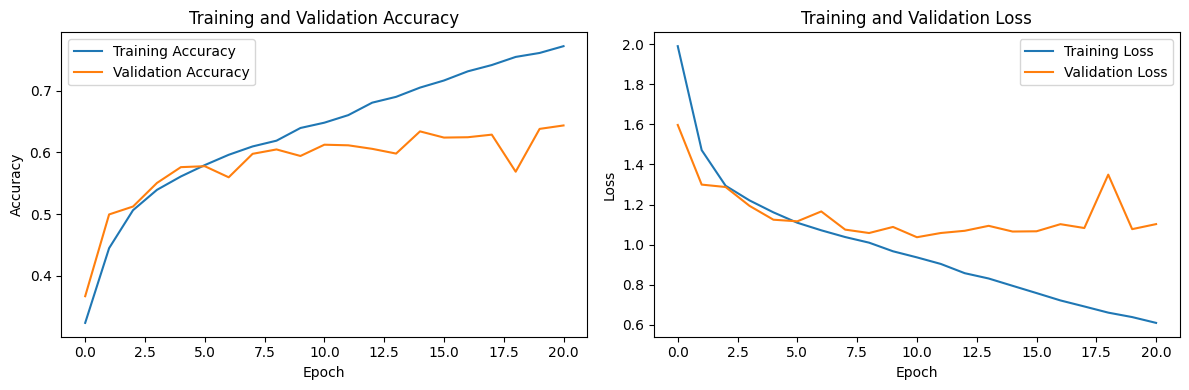

In [6]:
print("Evaluating Best Model...")
loss, accuracy = best_model.evaluate(val_ds)
print(f"Validation Loss: {loss:.4f}")
print(f"Validation Accuracy: {accuracy*100:.2f}%")


plt.figure(figsize=(12, 4))

# accuracy only
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# loss plot
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()